# Hipoteza IV
Istnieje silna, nieliniowa zależność między liczbą użytkowników a generowanym przychodem, co sugeruje rosnącą efektywność monetyzacji pojedynczego użytkownika.

Dane treningowe:
- roczne dane przychodów firmy meta z lat 2007-2017
- kwartalne dane liczby użytkowników z lat 2009-2017

Dane testowe:
- roczne dane przychodów firmy meta z lat 2018-2023
- kwartalne dane liczby użytkowników z lat 2018-2023

Wykorzystane modele:
- wykładniczy
- potęgowy
- wielomianowy

Zmienna objaśniana: przychody firmy Meta (Revenue)

Zmienna objaśniająca: liczba użytkowników (Users)

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

import importlib

from sklearn.metrics import mean_absolute_error

dane = importlib.import_module('Lab-1-Zadanie-1-Przygotowanie-danych')

In [2]:
# Kwartalne liczby użytkowników należy zagregować do postaci rocznej liczby użytkowników
# Ponieważ, interesuje nas relacja liczby użytkowników z przychodem firmy, najlepszym sposobem na agregację będzie średnia arytmetyczna liczby użytkowników w kwartałach
# taki sposób agregacji zachowuje informacje o możliwych fluktuacjach bazy użytkowników w danym roku

import pandas as pd

def dane_uzytkownicy() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    q_dane_uzytkownicy, q_dane_uzytkownicy_train, q_dane_uzytkownicy_test = dane.dane_uzytkownicy()

    def quarterly_to_yearly(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
        years = sorted(y for y in set(x.year for x in df['QY']))
        new_col = [np.average(df[df['QY'].apply(lambda x: x.year == year)][col_name]) for year in years]
        new_df = pd.DataFrame()
        new_df[col_name] = new_col
        new_df['Year'] = years
        return new_df

    dane_uzytkownicy = quarterly_to_yearly(q_dane_uzytkownicy, 'Users')
    dane_uzytkownicy_train = quarterly_to_yearly(q_dane_uzytkownicy_train, 'Users')
    dane_uzytkownicy_test = quarterly_to_yearly(q_dane_uzytkownicy_test, 'Users')
    return dane_uzytkownicy, dane_uzytkownicy_train, dane_uzytkownicy_test

def get_data() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    data_revenue, data_revenue_train, data_revenue_test = dane.dane_przychody()
    data_users, data_users_train, data_users_test = dane_uzytkownicy()

    min_year = max(min(data_users['Year']), min(data_revenue['Year']))
    max_year = min(max(data_users['Year']), max(data_revenue['Year']))

    data_revenue = data_revenue[data_revenue['Year'] >= min_year]
    data_revenue = data_revenue[data_revenue['Year'] <= max_year]

    data_revenue_test = data_revenue_test[data_revenue_test['Year'] >= min_year]
    data_revenue_test = data_revenue_test[data_revenue_test['Year'] <= max_year]

    data_revenue_train = data_revenue_train[data_revenue_train['Year'] >= min_year]
    data_revenue_train = data_revenue_train[data_revenue_train['Year'] <= max_year]

    data_users = data_users[data_users['Year'] >= min_year]
    data_users = data_users[data_users['Year'] <= max_year]

    data_users_test = data_users_test[data_users_test['Year'] >= min_year]
    data_users_test = data_users_test[data_users_test['Year'] <= max_year]

    data_users_train = data_users_train[data_users_train['Year'] >= min_year]
    data_users_train = data_users_train[data_users_train['Year'] <= max_year]

    data = pd.merge(data_revenue, data_users, on='Year')
    data_train = pd.merge(data_revenue_train, data_users_train, on='Year')
    data_test = pd.merge(data_revenue_test, data_users_test, on='Year')

    return data, data_train, data_test




## Model wykładniczy
Model wykładniczy służący jako punkt odwołania dla pozostałych modeli


Funkcja wykładnicza opisująca zjawisko \
$ W = b \cdot a^X $ \
, gdzie: \
$W$ -> 'Revenue' \
$X$ -> 'Users'

Linearyzacja funkcji:

$ Y = log(W) $ \
$ a_0 = log(b)$ \
$ a_1 = log(a)$

$ Y = a_1 \cdot X + a_0 $


PODSUMOWANIE MODELU WYKŁADNICZNEGO (dla danych 2007-2017)

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     419.0
Date:                Tue, 20 Jan 2026   Prob (F-statistic):           1.67e-07
Time:                        15:30:47   Log-Likelihood:                 4.0159
No. Observations:                   9   AIC:                            -4.032
Df Residuals:                       7   BIC:                            -3.637
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

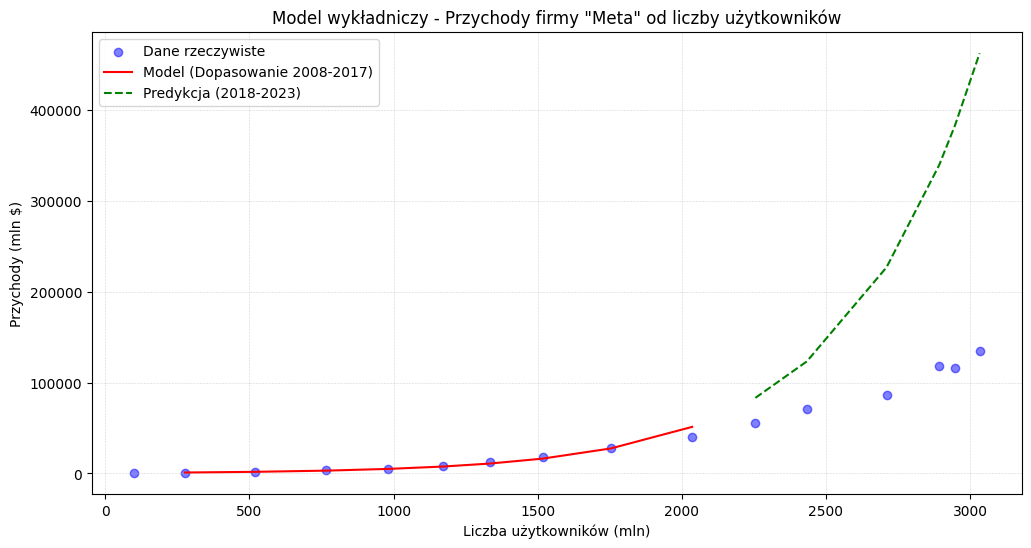

Średni błąd (MAE) dla lat 2018-2020: 73754.24 mln $
Średni błąd (MAE) dla lat 2021-2023: 272006.94 mln $


In [3]:
data, data_train, data_test = get_data()

# Definicja modelu
X_train = data_train['Users']
X_train = sm.add_constant(X_train)
Y_train = data_train['Revenue']

model_wykladniczy = sm.OLS(
    np.log(Y_train),
    X_train
).fit()

# Ocena modelu
print("PODSUMOWANIE MODELU WYKŁADNICZNEGO (dla danych 2007-2017)\n")
print(model_wykladniczy.summary())

X_pred = data_test['Users']
X_pred = sm.add_constant(X_pred)
Y_pred_wykl = model_wykladniczy.predict(X_pred)

plt.figure(figsize=(12, 6))
plt.scatter(data['Users'], data['Revenue'], color='blue', label='Dane rzeczywiste', alpha=0.5)
plt.plot(data_train['Users'], np.exp(model_wykladniczy.fittedvalues), color='red', label='Model (Dopasowanie 2008-2017)')
plt.plot(data_test['Users'], np.exp(Y_pred_wykl), color='green', linestyle='--', label='Predykcja (2018-2023)')

plt.title('Model wykładniczy - Przychody firmy "Meta" od liczby użytkowników')
plt.xlabel('Liczba użytkowników (mln)')
plt.ylabel('Przychody (mln $)')
#plt.xticks(range(min(data['NoY']), max(data['NoY']) + 1), labels=data['Year'], rotation=90)
plt.grid(which='major', linestyle=':', linewidth='0.4')
plt.legend()
plt.grid(True)
plt.show()

model_wykladniczy_mae_2018_2020 = mean_absolute_error(
    data_test[data_test['Year'] <= 2020]['Revenue'],
    np.exp(Y_pred_wykl[data_test['Year'] <= 2020])
)

model_wykladniczy_mae_2021_2023 = mean_absolute_error(
    data_test[data_test['Year'] >= 2021]['Revenue'],
    np.exp(Y_pred_wykl[data_test['Year'] >= 2021])
)

print(f"Średni błąd (MAE) dla lat 2018-2020: {model_wykladniczy_mae_2018_2020:.2f} mln $")
print(f"Średni błąd (MAE) dla lat 2021-2023: {model_wykladniczy_mae_2021_2023:.2f} mln $")



## Model potęgowy

Funkcja potęgowa opisująca zjawisko \
$ W = b \cdot X^a $ \
, gdzie: \
$W$ -> 'Revenue' \
$X$ -> 'Users'

Linearyzacja funkcji:

$ Y = log(W) $ \
$ X_1 = log(X) $ \
$ a_0 = log(b)$ \
$ a_1 = log(a)$

$ Y = a_1 \cdot X_1 + a_0 $


PODSUMOWANIE MODELU WYKŁADNICZNEGO (dla danych 2007-2017)

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     210.2
Date:                Tue, 20 Jan 2026   Prob (F-statistic):           1.77e-06
Time:                        15:30:47   Log-Likelihood:                0.98451
No. Observations:                   9   AIC:                             2.031
Df Residuals:                       7   BIC:                             2.425
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

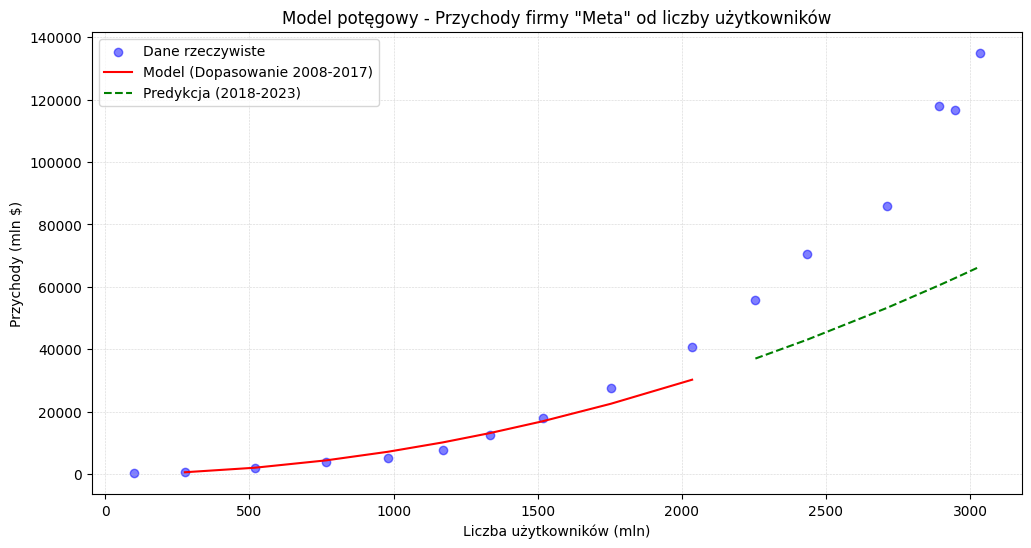

Średni błąd (MAE) dla lat 2018-2020: 26407.64 mln $
Średni błąd (MAE) dla lat 2021-2023: 59887.69 mln $


In [4]:
data, data_train, data_test = get_data()

# Definicja modelu
X_train = np.log(data_train['Users'])
X_train = sm.add_constant(X_train)
Y_train = data_train['Revenue']

model_potegowy = sm.OLS(
    np.log(Y_train),
    X_train
).fit()

# Ocena modelu
print("PODSUMOWANIE MODELU WYKŁADNICZNEGO (dla danych 2007-2017)\n")
print(model_potegowy.summary())

X_pred = np.log(data_test['Users'])
X_pred = sm.add_constant(X_pred)
Y_pred_pot = model_potegowy.predict(X_pred)

plt.figure(figsize=(12, 6))
plt.scatter(data['Users'], data['Revenue'], color='blue', label='Dane rzeczywiste', alpha=0.5)
plt.plot(data_train['Users'], np.exp(model_potegowy.fittedvalues), color='red',
         label='Model (Dopasowanie 2008-2017)')
plt.plot(data_test['Users'], np.exp(Y_pred_pot), color='green', linestyle='--', label='Predykcja (2018-2023)')

plt.title('Model potęgowy - Przychody firmy "Meta" od liczby użytkowników')
plt.xlabel('Liczba użytkowników (mln)')
plt.ylabel('Przychody (mln $)')
#plt.xticks(range(min(data['NoY']), max(data['NoY']) + 1), labels=data['Year'], rotation=90)
plt.grid(which='major', linestyle=':', linewidth='0.4')
plt.legend()
plt.grid(True)
plt.show()

model_potegowy_mae_2018_2020 = mean_absolute_error(
    data_test[data_test['Year'] <= 2020]['Revenue'],
    np.exp(Y_pred_pot[data_test['Year'] <= 2020])
)

model_potegowy_mae_2021_2023 = mean_absolute_error(
    data_test[data_test['Year'] >= 2021]['Revenue'],
    np.exp(Y_pred_pot[data_test['Year'] >= 2021])
)

print(f"Średni błąd (MAE) dla lat 2018-2020: {model_potegowy_mae_2018_2020:.2f} mln $")
print(f"Średni błąd (MAE) dla lat 2021-2023: {model_potegowy_mae_2021_2023:.2f} mln $")



## Model hybrydowy

Na podstawie wyników modelu wykładniczego i potęgowego, zauważono zależność:
- model wykładniczy 'przeszacowuje' przychody w latach 2018-2023
- model potęgowy 'nie doszacowuje' przychody w latach 2018-2023

Model dobrze opisujący przychody w latach 2018-2023 znajduje się zatem pomiędzy testowanymi modelami, a opisuje go średnia ważona obu modeli: \
$Y_{hybryda} = \alpha \cdot Y_{potęgowy} + (1 - \alpha) \cdot Y_{wykładniczy}$

Zadaniem stało się znalezienie najlepszej wartości $\alpha$. Parametr można wyznaczyć poprzez rozwiązanie zadania optymalizacyjnego, którego celem jest minimalizacja funkcji MAE. Funkcją MAE może być MAE wyników predykcji dla lat 2018-2020 lub 2021-2023, albo wyniki predykcji dla lat 2018-2023.

Po eksperymentach wybrano funkcję MAE wyników predykcji dla lat 2018-2023, ponieważ zwraca najlepsze wyniki.

Wyznaczona wartość alfa: 0.36
Wynik R^2 dla modelu hybrydowego: 0.978


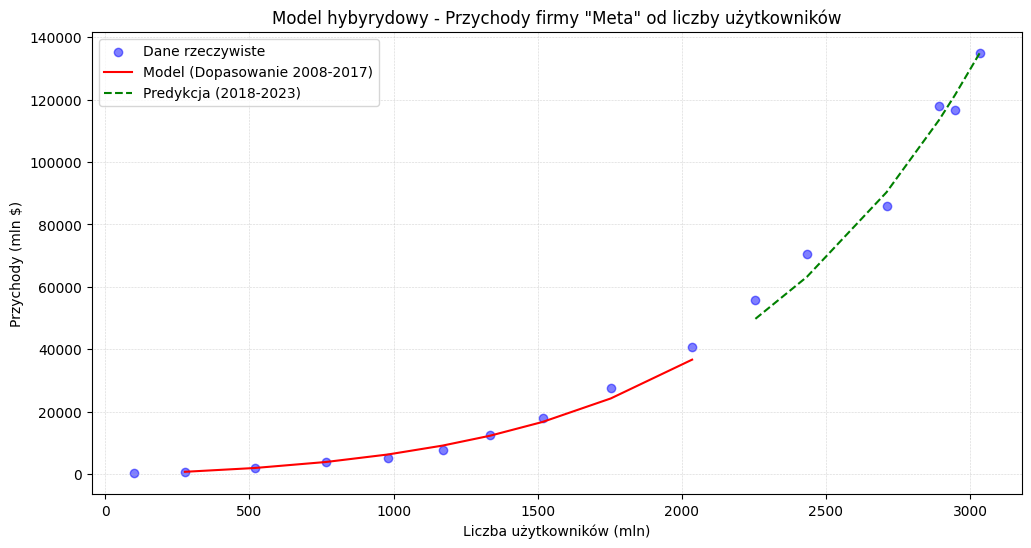

Średni błąd (MAE) dla lat 2018-2020: 5978.36 mln $
Średni błąd (MAE) dla lat 2021-2023: 3108.79 mln $


In [5]:

from sklearn.metrics import r2_score
from scipy.optimize import minimize_scalar

y_wykl = model_wykladniczy.fittedvalues
y_pot = model_potegowy.fittedvalues


def function(alfa):
    y = alfa * y_wykl + (1 - alfa) * y_pot
    pred = alfa * Y_pred_wykl + (1 - alfa) * Y_pred_pot

    mae_train = mean_absolute_error(
        data_train['Revenue'],
        y
    )

    mae_2018_2020 = mean_absolute_error(
        data_test[data_test['Year'] <= 2020]['Revenue'],
        np.exp(pred[data_test['Year'] <= 2020])
    )

    mae_2021_2023 = mean_absolute_error(
        data_test[data_test['Year'] >= 2021]['Revenue'],
        np.exp(pred[data_test['Year'] >= 2021])
    )

    mae_2018_2023 = mean_absolute_error(
        data_test['Revenue'],
        np.exp(pred)
    )

    # zwracana wartość decyduje co wpływa na wartość alfa
    return mae_2018_2023


alfa = minimize_scalar(function, bounds=(0, 1)).x
print(f"Wyznaczona wartość alfa: {alfa:.2f}")
Y_hyb = alfa * y_wykl + (1 - alfa) * y_pot
Y_pred_hyb = alfa * Y_pred_wykl + (1 - alfa) * Y_pred_pot

r2_hyb = r2_score(data_train['Revenue'], np.exp(Y_hyb))
print(f"Wynik R^2 dla modelu hybrydowego: {r2_hyb:.3f}")

plt.figure(figsize=(12, 6))
plt.scatter(data['Users'], data['Revenue'], color='blue', label='Dane rzeczywiste', alpha=0.5)
plt.plot(data_train['Users'], np.exp(Y_hyb), color='red', label='Model (Dopasowanie 2008-2017)')
plt.plot(data_test['Users'], np.exp(Y_pred_hyb), color='green', linestyle='--', label='Predykcja (2018-2023)')

plt.title('Model hybyrydowy - Przychody firmy "Meta" od liczby użytkowników')
plt.xlabel('Liczba użytkowników (mln)')
plt.ylabel('Przychody (mln $)')
plt.grid(which='major', linestyle=':', linewidth='0.4')
plt.legend()
plt.grid(True)
plt.show()

model_hybrydowy_mae_2018_2020 = mean_absolute_error(
    data_test[data_test['Year'] <= 2020]['Revenue'],
    np.exp(Y_pred_hyb[data_test['Year'] <= 2020])
)

model_hybrydowy_mae_2021_2023 = mean_absolute_error(
    data_test[data_test['Year'] >= 2021]['Revenue'],
    np.exp(Y_pred_hyb[data_test['Year'] >= 2021])
)

print(f"Średni błąd (MAE) dla lat 2018-2020: {model_hybrydowy_mae_2018_2020:.2f} mln $")
print(f"Średni błąd (MAE) dla lat 2021-2023: {model_hybrydowy_mae_2021_2023:.2f} mln $")


## Model wielomianowy


PODSUMOWANIE MODELU WIELOMIANOWEGO (dla danych 2007-2017)

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3930.
Date:                Tue, 20 Jan 2026   Prob (F-statistic):           6.90e-11
Time:                        15:30:48   Log-Likelihood:                -69.313
No. Observations:                   9   AIC:                             142.6
Df Residuals:                       7   BIC:                             143.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

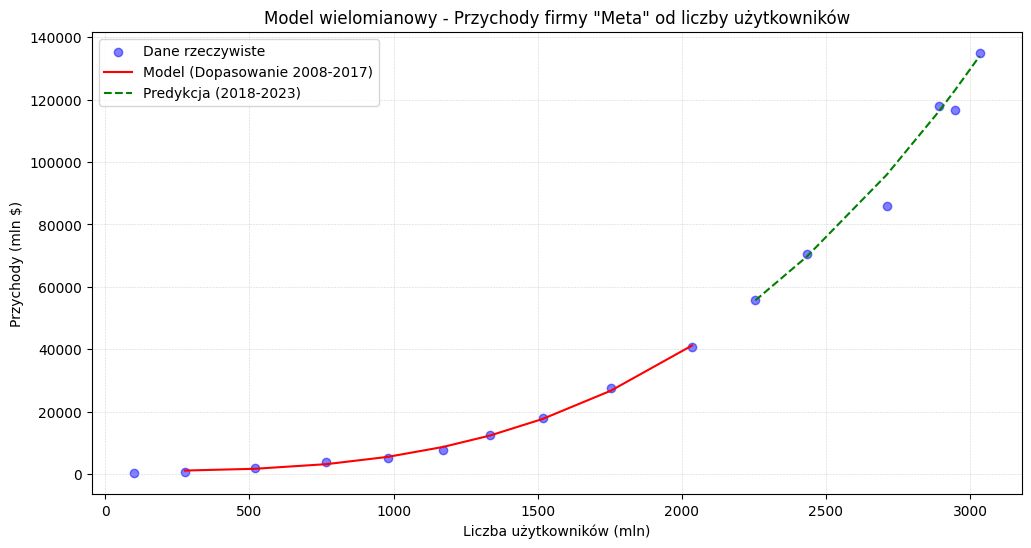

Średni błąd (MAE) dla lat 2018-2020: 3679.49 mln $
Średni błąd (MAE) dla lat 2021-2023: 2988.93 mln $


In [6]:
import pandas as pd

data, data_train, data_test = get_data()


# Definicja modelu
X_train = pd.DataFrame()
#X_train['X1'] = data_train['Users']
#X_train['X2'] = data_train['Users'] ** 2
X_train['X3'] = data_train['Users'] ** 3
#X_train['X4'] = data_train['Users'] ** 4
X_train = sm.add_constant(X_train)
Y_train = data_train['Revenue']

model_wielomianowy = sm.OLS(
    Y_train,
    X_train
).fit()

# Ocena modelu
print("PODSUMOWANIE MODELU WIELOMIANOWEGO (dla danych 2007-2017)\n")
print(model_wielomianowy.summary())

X_pred = pd.DataFrame()
#X_pred['X1'] = data_test['Users']
#X_pred['X2'] = data_test['Users'] ** 2
X_pred['X3'] = data_test['Users'] ** 3
#X_pred['X4'] = data_test['Users'] ** 4
X_pred = sm.add_constant(X_pred)
Y_pred_wiel = model_wielomianowy.predict(X_pred)

plt.figure(figsize=(12, 6))
plt.scatter(data['Users'], data['Revenue'], color='blue', label='Dane rzeczywiste', alpha=0.5)
plt.plot(data_train['Users'], model_wielomianowy.fittedvalues, color='red', label='Model (Dopasowanie 2008-2017)')
plt.plot(data_test['Users'], Y_pred_wiel, color='green', linestyle='--', label='Predykcja (2018-2023)')

plt.title('Model wielomianowy - Przychody firmy "Meta" od liczby użytkowników')
plt.xlabel('Liczba użytkowników (mln)')
plt.ylabel('Przychody (mln $)')
plt.grid(which='major', linestyle=':', linewidth='0.4')
plt.legend()
plt.grid(True)
plt.show()

model_wielomianowy_mae_2018_2020 = mean_absolute_error(
    data_test[data_test['Year'] <= 2020]['Revenue'],
    Y_pred_wiel[data_test['Year'] <= 2020]
)

model_wielomianowy_mae_2021_2023 = mean_absolute_error(
    data_test[data_test['Year'] >= 2021]['Revenue'],
    Y_pred_wiel[data_test['Year'] >= 2021]
)

print(f"Średni błąd (MAE) dla lat 2018-2020: {model_wielomianowy_mae_2018_2020:.2f} mln $")
print(f"Średni błąd (MAE) dla lat 2021-2023: {model_wielomianowy_mae_2021_2023:.2f} mln $")



In [7]:

data, data_train, data_test = get_data()

x_1 = data_test['Users'].tail(1)
x_2 = x_1 * 1.05

X_1 = pd.DataFrame()
X_1["X3"] = x_1 ** 3
X_1["const"] = [0]

X_2 = pd.DataFrame()
X_2["X3"] = x_2 ** 3
X_2["const"] = [0]

Y_1 = model_wielomianowy.predict(X_1)
Y_2 = model_wielomianowy.predict(X_2)

print(f'\nPrzy 5% wzroście bazy użytkowników przychód wzrósł o {((Y_2-Y_1)/Y_1).values[0] * 100:.2f} %')



Przy 5% wzroście bazy użytkowników przychód wzrósł o 15.76 %
